# 케글 산탄데르 고객만족(Santandel Customer Satisfaction) 데이터 세트

### 케글 산탄데르 고객 만족 예측 대회

* 대회 개요
https://www.kaggle.com/c/santander-customer-satisfaction

- 불만고객(1) 분류하기
성능평가: ROC-AUC ( 대부분이 만족이고 불만족인 데이터는 소수인 불균형 데이터세트)

- 데이터셋 다운로드: 
https://www.kaggle.com/c/santander-customer-satisfaction/data

- 다운로드 후 데이터셋 이름 변경
train.csv -> train_santander.csv
test.csv -> test_santander.csv 

- XGBoost, LightGBM으로 예측

In [1]:
# 관련 파일 임포트

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

from sklearn.datasets import load_breast_cancer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost

import warnings
warnings.filterwarnings('ignore')

### 데이터 전처리

In [2]:
train = pd.read_csv('santander-customer-satisfaction/train_santander.csv')
train

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


*  레이블 (Target) 의 분포 확인(불만족 고객 비율)

In [9]:
# train['TARGET'].sum()/len(train['TARGET']) #0.0395685345961589
train['TARGET'].sum()

3008

In [11]:
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [12]:
train['var3'].describe()

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64

In [13]:
# var3 피처 값 대체 및 ID 피처 드롭
train['var3'] = train['var3'].replace(-999999, 2)
train = train.drop('ID', axis=1)

train.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,2.716483,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,9.447971,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [15]:
# 피처 세트와 레이블 세트분리. 
X = train.iloc[:,:-1]
y = train['TARGET']

In [16]:
# train, test set 분리: test_size=0.2, random_state=0
# 불균형 데이터이므로 학습세트와 테스트세트에 레이블 분포가 유사한지 확인
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60816, 369), (15204, 369), (60816,), (15204,))

## 1. XGBoost 모델 

### XGBoost 모델 학습

In [ ]:
?XGBClassifier.fit

In [17]:
# n_estimators=500, random state=156
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=156)
xgb.fit(X_train, y_train)

y_pred_train = xgb.predict(X_train)
print(f'train_score: {accuracy_score(y_train, y_pred_train)}')
y_pred_test = xgb.predict(X_test)
print(f'test_score: {accuracy_score(y_test, y_pred_test)}')


train_score: 0.9611450933964746
test_score: 0.9582346750855039


In [18]:
# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
#
### 2.1. 조기 종료 옵션을 사용한 경우
# save_best = True를 사용하지 않는 경우
# early_stopping_rounds만 사용

xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=156)
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', 
        eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.69071
[1]	validation_0-auc:0.76974
[2]	validation_0-auc:0.76974
[3]	validation_0-auc:0.76974
[4]	validation_0-auc:0.76974
[5]	validation_0-auc:0.76974
[6]	validation_0-auc:0.76974
[7]	validation_0-auc:0.76974
[8]	validation_0-auc:0.76974
[9]	validation_0-auc:0.76974
[10]	validation_0-auc:0.76974
[11]	validation_0-auc:0.76974
[12]	validation_0-auc:0.76974
[13]	validation_0-auc:0.76974
[14]	validation_0-auc:0.76974
[15]	validation_0-auc:0.76974
[16]	validation_0-auc:0.76974
[17]	validation_0-auc:0.76974
[18]	validation_0-auc:0.76974
[19]	validation_0-auc:0.77243
[20]	validation_0-auc:0.77243
[21]	validation_0-auc:0.77243
[22]	validation_0-auc:0.77243
[23]	validation_0-auc:0.77243
[24]	validation_0-auc:0.77243
[25]	validation_0-auc:0.77243
[26]	validation_0-auc:0.77243
[27]	validation_0-auc:0.78084
[28]	validation_0-auc:0.77243
[29]	validation_0-auc:0.78393
[30]	validation_0-auc:0.77523
[31]	validation_0-auc:0.78393
[32]	validation_0-auc:0.77523
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=156, ...)

In [31]:
# print('최적 파라미터:', xgb.best_params_)

xgb_roc_score = roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:', xgb_roc_score)

ROC AUC: 0.8385857245236205


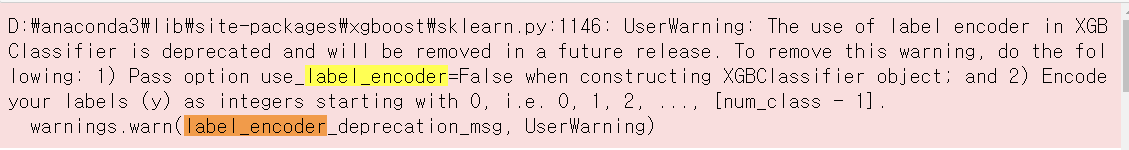

In [ ]:
# warning 제거를 위해 y_train, y_test 자료구조를 numpy로 바꿔줌
y_train = np.array(y_train)
y_test = np.array(y_test)

### test

In [27]:
test = pd.read_csv('santander-customer-satisfaction/test_santander.csv')
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [28]:
test.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
count,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,...,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,75818.000000,7.581800e+04
mean,75874.830581,-1579.955011,33.138832,83.164329,74.312894,123.136448,4.578517,7.666855,0.470645,0.672444,...,0.160595,12.438559,1.327408,17.469991,12.674349,63.597839,11.404505,95.973025,70.504319,1.173863e+05
std,43882.370827,39752.473358,12.932000,1694.873886,364.211245,606.431562,133.383326,239.701416,34.028605,42.336668,...,32.441677,958.651673,170.449935,1252.618781,895.165516,3754.668954,1061.858193,4658.871575,3318.527783,2.479384e+05
min,2.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.600000,-0.600000,0.000000,0.000000,0.000000,0.000000,1.202730e+03
25%,37840.250000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.754961e+04
50%,75810.000000,2.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.057643e+05
75%,113996.500000,2.000000,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.183159e+05
max,151837.000000,238.000000,105.000000,240000.000000,21093.960000,47943.960000,21093.960000,47943.960000,6600.000000,6600.000000,...,8030.160000,146605.320000,40080.600000,162355.800000,138054.960000,453893.400000,217762.230000,496198.080000,354260.730000,2.889440e+07


In [30]:
# var3 피처 값 대체 및 ID 피처 드롭
test['var3'] = test['var3'].replace(-999999, 2)
test = test.drop('ID', axis=1)

#### 첫 번째 하이퍼파라미터 튜닝 (0.8404 -> ?? )

In [ ]:


# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소


# cv는 3으로 지정 


#### 두번째 하이퍼파라미터 튜닝.( 0. 8455 -> 0.8453)

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 


*  특성 중요도시각화

## 2.  LightGBM 모델 

In [20]:
import lightgbm as lgb

In [ ]:
?LGBMClassifier.fit

####  첫번째 하이퍼 파라미터 튜닝(0.8409 -> ? 0.8417)

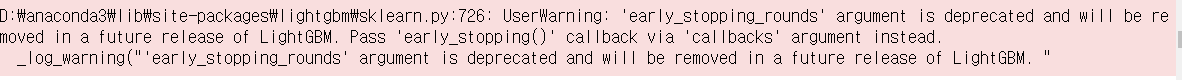

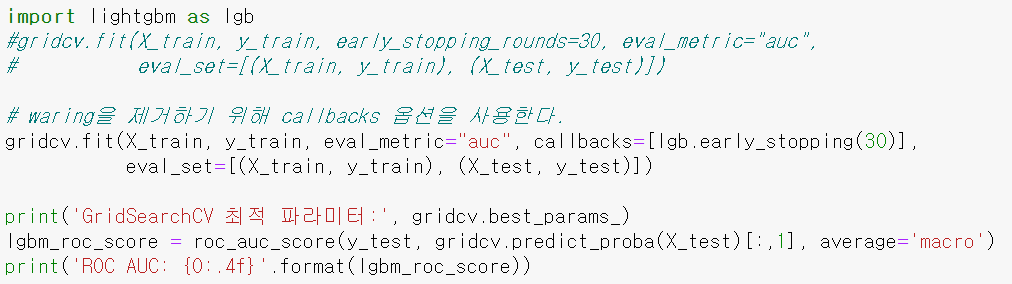

In [21]:
gridcv.fit(X_train, y_train, eval_metric='auc', 
        eval_set=[(X_train, y_train),(X_test, y_test)])
print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(ytest, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC:', lgbm_roc_score)

NameError: name 'gridcv' is not defined